### TonEd Notebook

In [1]:
#import our stuff here
import IPython, numpy as np, scipy as sp, matplotlib.pyplot as plt, matplotlib, sklearn, librosa, math, os, random
%matplotlib inline
import librosa.display as display
from IPython.display import Audio
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn import tree, linear_model
from sklearn.utils import shuffle
from sklearn.metrics import confusion_matrix


In [4]:
def extract_features(audio, sr):
    mfccs = librosa.feature.mfcc(y=audio, sr=sr)[1:14, :]
    mean_mfccs = np.mean(mfccs, axis = 1)
    var_mfccs = np.var(mfccs, axis = 1)
    delta_mfccs = np.diff(mfccs, axis = 1)
    mean_delta_mfccs = np.mean(delta_mfccs, axis = 1)
    var_delta_mfccs = np.var(delta_mfccs, axis = 1)
    #return np.concatenate([var_mfccs, var_delta_mfccs])
    return np.concatenate([mean_mfccs, var_mfccs, mean_delta_mfccs, var_delta_mfccs])
    
def analyze_results(results):
    true_positives = sum([r[0] == r[1] for r in results])
    false_positives = sum([r[0] != r[1] for r in results])
    precision = true_positives / float(true_positives + false_positives)
    return precision

def print_results(method, results):
    print "~~~ " + method + " Results ~~~"
    print "Precision: " + str(analyze_results(results))
    print "Confusion matrix:"
    print confusion_matrix([r[0] for r in results], [r[1] for r in results])
    print ""
    
def features_by_person(name):
    fullstr = "samples/" + name + "_Full.wav"
    crunchystr = "samples/" + name + "_Crunchy.wav"
    thinstr = "samples/" + name + "_Thin.wav"
    
    sr = 44100.
    full, sr = librosa.load(fullstr, sr)
    crunchy, sr = librosa.load(crunchystr, sr)
    thin, sr = librosa.load(thinstr, sr)
    
    full_features = extract_features(full, sr)
    crunchy_features = extract_features(crunchy, sr)
    thin_features = extract_features(thin, sr)
    
    return [full_features, thin_features, crunchy_features], ["Full", "Thin", "Crunchy"]

def features_by_tone(tone):
    features = []
    classes = []
    for file in os.listdir("samples/"):
        if file.endswith(tone + ".wav"):
            sr = 44100.
            pathstr = os.path.join("samples/", file)
            sample, sr = librosa.load(pathstr, sr)
            frames = librosa.util.frame(sample, 26460, hop_length = 26460)
            for frame in range(frames.shape[-1]):
                feature = extract_features(frames[:, frame], sr)
                features.append(feature)
                classes.append(tone)
    
    return features, classes

def run_model(features, classes, model, folds):
    results = []
    for i in range(folds):
        start = i*all_features.shape[0]/folds
        stop = (i+1)*all_features.shape[0]/folds
        cross_validation_set = np.concatenate((all_features[0:start, :], all_features[stop:, :]))
        cross_validation_classes = np.concatenate((all_classes[0:start], all_classes[stop:]))

        if model == "SVM":
            clf = sklearn.svm.SVC()
        elif model == "Nearest Neighbor":
            clf = KNeighborsClassifier(n_neighbors=15, algorithm='auto')
        elif model == "Decision Tree":
            clf = tree.DecisionTreeClassifier()
        elif model == "Stochastic Gradient Descent":
            clf = linear_model.SGDClassifier()
        elif model == "Multi-layer Perceptron":
            clf = MLPClassifier()
        else:
            print model +" is not a valid model."
            return
        
        clf.fit(cross_validation_set, cross_validation_classes)  
        for j in range(start, stop):        
            result = clf.predict(all_features[j, :].reshape(1, -1))
            results.append((all_classes[j], result))

    print_results(model, results)


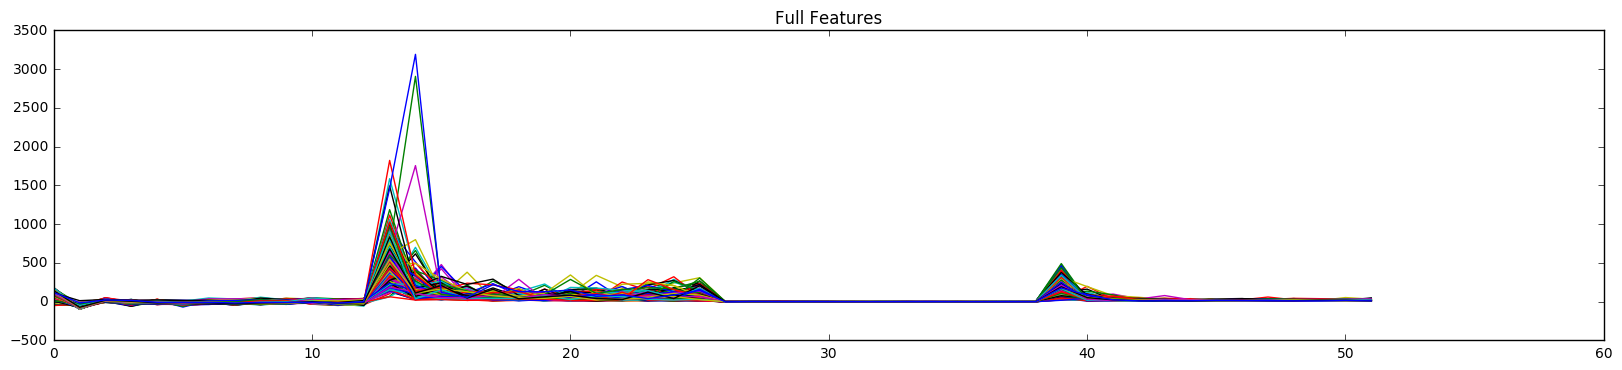

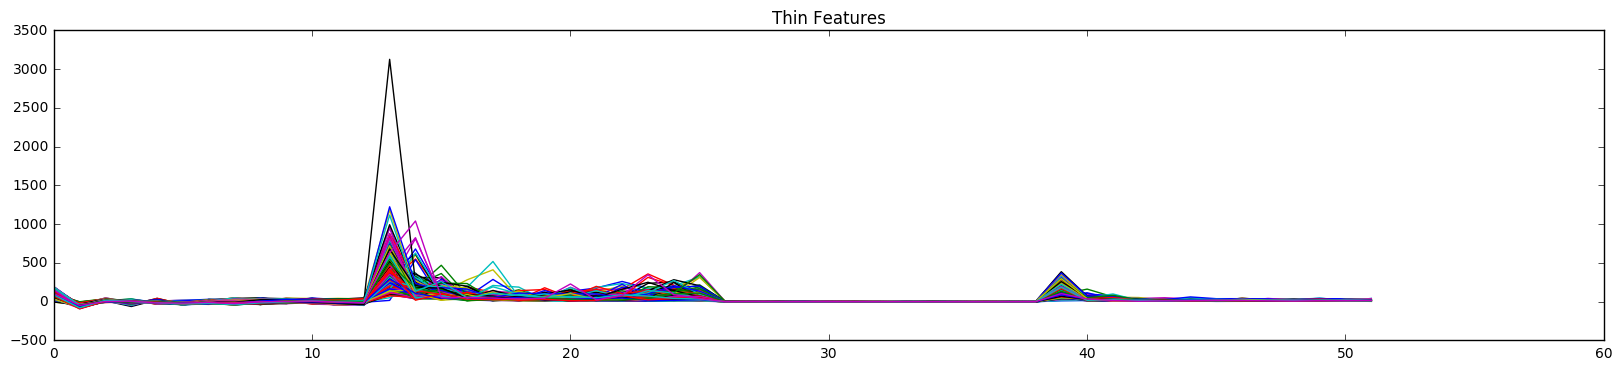

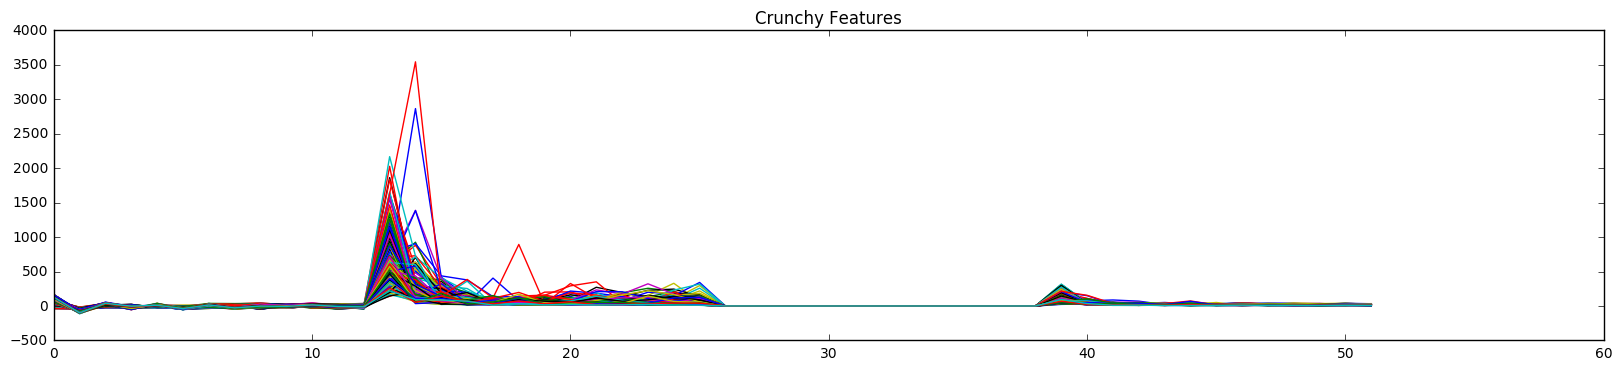

~~~ Decision Tree Results ~~~
Precision: [ 0.52399232]
Confusion matrix:
[[104  50  18]
 [ 55  72  49]
 [ 21  55  97]]

~~~ Nearest Neighbor Results ~~~
Precision: [ 0.51055662]
Confusion matrix:
[[116  38  18]
 [ 67  66  43]
 [ 36  53  84]]

~~~ Stochastic Gradient Descent Results ~~~
Precision: [ 0.49520154]
Confusion matrix:
[[80 64 28]
 [44 91 41]
 [20 66 87]]

~~~ SVM Results ~~~
Precision: [ 0.26871401]
Confusion matrix:
[[ 26 116  30]
 [ 47  93  36]
 [ 43 109  21]]

~~~ Multi-layer Perceptron Results ~~~
Precision: [ 0.55278311]
Confusion matrix:
[[114  37  21]
 [ 40  74  62]
 [ 25  48 100]]



In [5]:
#get full features
full_features, full_classes = features_by_tone("Full")
plt.figure(figsize=(20, 4))
for feat in full_features:
    plt.plot(feat)
    plt.title("Full Features")
plt.show()

#get thin features
thin_features, thin_classes = features_by_tone("Thin")
plt.figure(figsize=(20, 4))
for feat in thin_features:
    plt.plot(feat)
    plt.title("Thin Features")
plt.show()

#get crunchy features
crunchy_features, crunchy_classes = features_by_tone("Crunchy")
plt.figure(figsize=(20, 4))
for feat in crunchy_features:
    plt.plot(feat)
    plt.title("Crunchy Features")
plt.show()

#concatenate all features together
all_features = np.concatenate([full_features, thin_features, crunchy_features])
all_classes = np.concatenate([full_classes, thin_classes, crunchy_classes])
#shuffle the order!!
all_features, all_classes = shuffle(all_features, all_classes)

#run different models
run_model(all_features, all_classes, "Decision Tree", 18)
run_model(all_features, all_classes, "Nearest Neighbor", 18)
run_model(all_features, all_classes, "Stochastic Gradient Descent", 18)
run_model(all_features, all_classes, "SVM", 18)
run_model(all_features, all_classes, "Multi-layer Perceptron", 18)
